In [1]:
import numpy as np
import matplotlib.pyplot as plt
from get_onsets_from_scv import get_onsets_and_conditions_form_csv
import time
import statsmodels.api as sm
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
import mne 
import scipy.io as sio
import mat73

In [2]:
path_folder = '/Users/dac/Desktop/unfold_comparison/'
timelimits = [-.2,.4] #307  samples per predictor * 4
sr = 512
y_eeg = mat73.loadmat(path_folder + 'y_eeg.mat')
y_eeg = y_eeg['y_eeg']
times = mat73.loadmat(path_folder + 'eegTimes.mat')
times = times['times']
X_matlab = mat73.loadmat(path_folder + 'unfoldXmatrix.mat')
X_matlab=X_matlab['X']
X_matlab_sparse = csr_matrix(X_matlab)

## 0. Unfold results

Text(0.5, 1.0, 'unfold alone importted from MATLAB')

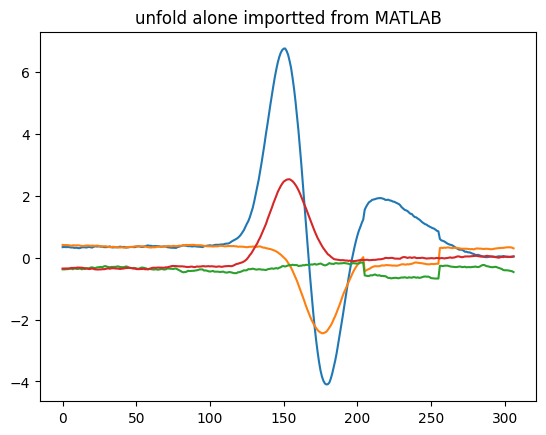

In [3]:
#load unfold actual solutions
results = sio.loadmat(path_folder + 'resultUnfold.mat')
results = results['results']
results = results.squeeze()
plt.plot(results);
plt.title('unfold alone importted from MATLAB')

### 1 Replicate the unfold solution using the imported version of the design matrix from MATLAB

In [4]:
import time
start_time = time.time()

model_matlab = LinearRegression()
model_matlab.fit(X_matlab_sparse, y_eeg)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Elapsed time: 0.115440 seconds


In [5]:
#calculate R^2
y_pred = model_matlab.predict(X_matlab_sparse)
y_true = y_eeg
RSS = ((y_true - y_pred)** 2).sum()
sigm_sq = RSS/(X_matlab.shape[0]-X_matlab.shape[1]-1)
XTX_inv = np.linalg.inv(np.dot(X_matlab.T, X_matlab))
error_total_matlab = np.diag(XTX_inv)*sigm_sq


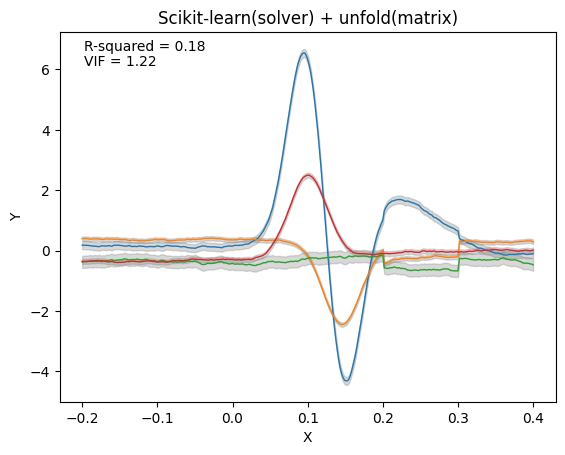

In [6]:
n_predictors = 3 
n_samples_window = 307
r_sq = model_matlab.score(X_matlab_sparse, y_eeg)


#plt.plot(model.coef_)
x         = np.linspace(timelimits[0],timelimits[1],n_samples_window)

fig, ax = plt.subplots()

for beta in range(n_predictors+1):
    idx = np.arange(beta*n_samples_window,beta*n_samples_window+n_samples_window) 
    y   = model_matlab.coef_[idx]
    error = error_total_matlab[idx]
    ax.plot(x, y, lw=1)
    ax.fill_between(x, y-error, y+error, color='gray', alpha=0.3)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scikit-learn(solver) + unfold(matrix)')
plt.annotate('R-squared = {:.2f}'.format(r_sq), xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate('VIF = {:.2f}'.format(1/(1-r_sq)), xy=(0.05, 0.91), xycoords='axes fraction')

# Show the plot
plt.show()

## 2. Fit the model with the design matrix created from scratch

In [7]:
import pandas as pd
csv_filepath ='~/Desktop/unfold_comparison/eventsE01.csv'
#Read the CSV file of events and extract the desired column as a list
df = pd.read_csv(csv_filepath)
#get preditor arrays from EEG.event (already clean)
df_conditions = df.loc[:, ['type', 'object','VSNT_EX','fixationRank','latency']]  # Select 'name' and 'gender' columns
df_conditions['type'] = 1*(df_conditions['type']=='fixation')

In [8]:
def closest_indices(arr1, arr2):
    closest_indices = np.empty_like(arr2, dtype=np.intp)

    # Iterate over the values in arr2.
    for i, val in np.ndenumerate(arr2):
        # Find the index of the closest value in arr1.
        closest_index = np.abs(arr1 - val).argmin()
        closest_indices[i] = closest_index
    return closest_indices

In [9]:
#building design matrix from scratch
n_predictors = 3 
n_samples_window = 307
timelimits = [-.2,.4] #307  samples per predictor * 4
sr = 512

expanded_params = (1+n_predictors)*n_samples_window
signal_longitud_in_samples = len(y_eeg)

X = np.zeros([signal_longitud_in_samples, expanded_params])

x         = np.linspace(timelimits[0],timelimits[1],n_samples_window)

zero_idx=closest_indices(x,0)
evt_lat = df_conditions.iloc[:,-1].values

for beta in range(n_predictors+1):
    
    j_idx = np.arange(beta*n_samples_window,beta*n_samples_window+n_samples_window)   
    for j in j_idx:   
        for i in range(len(evt_lat)):
            X[evt_lat[i]+j-beta*n_samples_window-zero_idx,j] = df_conditions.iloc[:,beta].values[i]

In [10]:
X_sparse = csr_matrix(X)

In [11]:
import time
start_time = time.time()

model = LinearRegression()
model.fit(X_sparse, y_eeg)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Elapsed time: 0.118096 seconds


In [12]:
#calculate R^2
y_pred = model.predict(X_sparse)
y_true = y_eeg
RSS = ((y_true - y_pred)** 2).sum()
sigm_sq = RSS/(X.shape[0]-X.shape[1]-1)
XTX_inv = np.linalg.inv(np.dot(X.T, X))
error_total = np.diag(XTX_inv)*sigm_sq


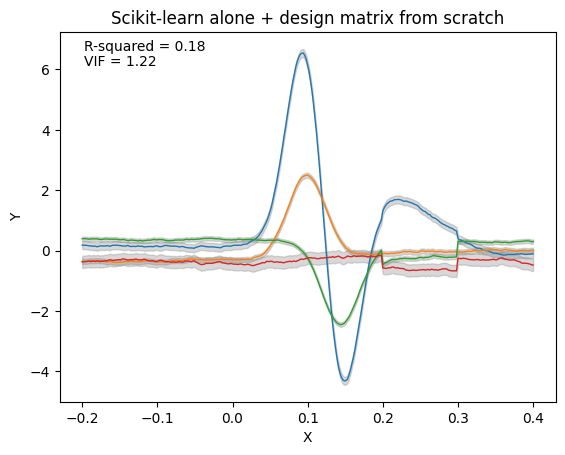

In [13]:
n_predictors = 3 
n_samples_window = 307
r_sq = model.score(X_sparse, y_eeg)


#plt.plot(model.coef_)
x         = np.linspace(timelimits[0],timelimits[1],n_samples_window)

fig, ax = plt.subplots()

for beta in range(n_predictors+1):
    idx = np.arange(beta*n_samples_window,beta*n_samples_window+n_samples_window) 
    y   = model.coef_[idx]
    error = error_total[idx]
    ax.plot(x, y, lw=1)
    ax.fill_between(x, y-error, y+error, color='gray', alpha=0.3)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scikit-learn alone + design matrix from scratch')
plt.annotate('R-squared = {:.2f}'.format(r_sq), xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate('VIF = {:.2f}'.format(1/(1-r_sq)), xy=(0.05, 0.91), xycoords='axes fraction')

# Show the plot
plt.show()

## 3.Use bootstrap to asses error for the $\beta 's$

In [17]:
from sklearn.utils import resample


# create a sparse matrix X and y for demonstration purposes
X = X_sparse
y_true

# define the number of bootstrap samples and the size of each sample
n_bootstraps = 1000
sample_size = X.shape[0]

# create an instance of the linear regression model
lr = LinearRegression()

# create a matrix to store the bootstrap estimates of the coefficients
boot_coef = np.empty([n_bootstraps,(n_predictors+1)*n_samples_window])

# perform the bootstrap
for i in range(n_bootstraps):
    # randomly sample the indices of the observations with replacement
    indices = resample(range(sample_size), replace=True)
    # select the corresponding rows of the sparse matrix X and the target vector y
    X_sample = X[indices]
    y_sample = [y_true[j] for j in indices]
    # fit the linear regression model to the bootstrap sample
    lr.fit(X_sample, y_sample)
    print(f'the botstrap sample data {i} was fitted')
    # store the estimates of the coefficients
    boot_coef[i,:]=lr.coef_

# calculate the bootstrap mean and standard error for each coefficient
boot_mean = [sum([coef[i] for coef in boot_coef])/n_bootstraps for i in range(X.shape[1])]
boot_std_error = [((sum([(coef[i] - boot_mean[i])**2 for coef in boot_coef])/(n_bootstraps-1))/n_bootstraps)**0.5 for i in range(X.shape[1])]

print("Bootstrap mean estimates of the coefficients:", boot_mean)
print("Bootstrap standard errors of the coefficients:", boot_std_error)


#bootstrap errors

bootstrap_mean = np.mean(boot_coef,axis=0)
bootstrap_std = np.std(boot_coef,axis=0)

# Calculate the 95% confidence interval using percentile method
lower_bound = np.percentile(boot_coef, 2.5,axis=0)
upper_bound = np.percentile(boot_coef, 97.5,axis=0)

the botstrap sample data 0 was fitted
the botstrap sample data 1 was fitted
the botstrap sample data 2 was fitted
the botstrap sample data 3 was fitted
the botstrap sample data 4 was fitted
the botstrap sample data 5 was fitted
the botstrap sample data 6 was fitted
the botstrap sample data 7 was fitted
the botstrap sample data 8 was fitted
the botstrap sample data 9 was fitted
the botstrap sample data 10 was fitted
the botstrap sample data 11 was fitted
the botstrap sample data 12 was fitted
the botstrap sample data 13 was fitted
the botstrap sample data 14 was fitted
the botstrap sample data 15 was fitted
the botstrap sample data 16 was fitted
the botstrap sample data 17 was fitted
the botstrap sample data 18 was fitted
the botstrap sample data 19 was fitted
the botstrap sample data 20 was fitted
the botstrap sample data 21 was fitted
the botstrap sample data 22 was fitted
the botstrap sample data 23 was fitted
the botstrap sample data 24 was fitted
the botstrap sample data 25 was fit

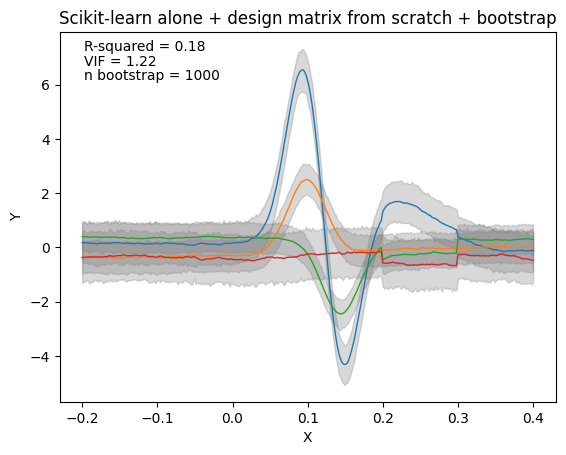

In [20]:
n_predictors = 3 
n_samples_window = 307
r_sq = model.score(X_sparse, y_eeg)


#plt.plot(model.coef_)
x         = np.linspace(timelimits[0],timelimits[1],n_samples_window)

fig, ax = plt.subplots()

for beta in range(n_predictors+1):
    idx = np.arange(beta*n_samples_window,beta*n_samples_window+n_samples_window) 
    y   = model.coef_[idx]
    error = error_total[idx]
    ax.plot(x, y, lw=1)
    ax.fill_between(x, lower_bound[idx], upper_bound[idx], color='gray', alpha=0.3)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scikit-learn alone + design matrix from scratch + bootstrap')
plt.annotate('R-squared = {:.2f}'.format(r_sq), xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate('VIF = {:.2f}'.format(1/(1-r_sq)), xy=(0.05, 0.91), xycoords='axes fraction')
plt.annotate('n bootstrap = {:.0f}'.format(n_bootstraps), xy=(0.05, 0.87), xycoords='axes fraction')

# Show the plot
plt.show()

## 4.Traditional FRP

In [30]:
latencies = df_conditions['latency'].values
erp= np.empty((len(latencies),307))
for epoch_onset in latencies:
    idx = np.arange(epoch_onset-102, epoch_onset+205)
    tmp=y_true[idx]
    erp+=tmp
err = np.std(erp,axis=0)
erp = np.mean(erp,axis=0)


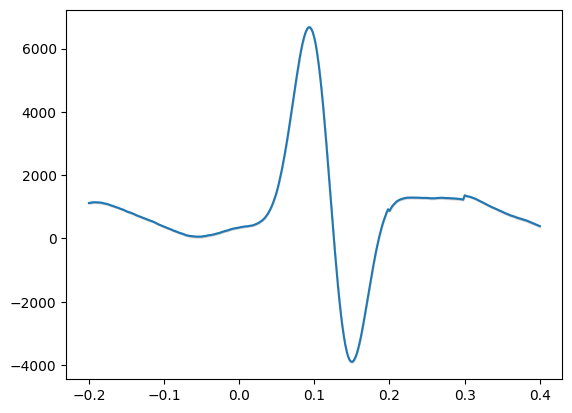

In [40]:
t = np.linspace(-.2,.4,len(erp))
plt.plot(t,erp)
plt.fill_between(t,erp-err, erp+err, color='gray', alpha=0.3)



array([1.42622617, 1.43084403, 1.53746105, ..., 4.34321128, 4.49222643,
       4.49114023])

In [46]:
X_matlab[:2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [4]:
df

,type,latency,urevent,duration,endtime,sac_amplitude,sac_endpos_x,sac_endpos_y,sac_startpos_x,sac_startpos_y,...,fix_avgpos_x,fix_avgpos_y,fix_avgpupilsize,sac_angle,fixationRank,catRank,NTF_NTO,stimulusDur,object,VSNT_EX
0,fixation,356,23204,83,0,0,0,0,0,0,...,522.124573,161.215851,0,0,0.241502,1,0,0.162109,0,0
1,fixation,476,23205,108,0,0,0,0,0,0,...,931.817810,173.893768,0,0,0.243145,1,1,0.210938,1,1
2,fixation,604,23206,145,0,0,0,0,0,0,...,1039.550049,174.363266,0,0,0.154159,1,1,0.283203,1,1
3,fixation,783,23207,61,0,0,0,0,0,0,...,847.283508,264.328094,0,0,0.956416,1,0,0.119141,0,1
4,fixation,884,23208,64,0,0,0,0,0,0,...,578.883606,470.820007,0,0,0.935661,0,0,0.125000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,fixation,454140,29090,122,0,0,0,0,0,0,...,1319.046387,237.841492,0,0,0.509839,1,0,0.238281,0,0
781,fixation,454290,29091,68,0,0,0,0,0,0,...,1118.756470,234.360077,0,0,0.974191,1,0,0.132812,0,0
782,fixation,454381,29092,104,0,0,0,0,0,0,...,1066.085815,258.163025,0,0,0.197279,1,0,0.203125,0,1
783,fixation,454843,29096,80,0,0,0,0,0,0,...,1073.879639,430.616943,0,0,0.111185,1,1,0.156250,1,0
